## **Problem**

Clustering Donald Trump's tweets 

## **Dataset**

Donald Trump's tweets (only text) from January 1st 2017 to January 1st 2018

http://www.trumptwitterarchive.com/archive




## **Model**
k-means clustering with euclidean distance

https://en.wikipedia.org/wiki/K-means_clustering




In [0]:
#header for accessing google drive
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

#loading dataset
#Place the file tweets.xlsx in the main folder of your google drive
"/content/drive/tweets.xlsx"
dataset_path = "/content/drive/Colab_Notebooks/Mathematical_Data_Science/tweets.xlsx"
raw_dataset = pd.read_excel(dataset_path, encoding = 'latin1')
dataset = raw_dataset.copy()


## **Data preprocessing**
- Tokenization: split the text into units (words)
- Removing punctuation
- Filtering stopwords: removing common English words that don't provide information (what, the, is...)
- Stemming and lemmatization:  reduce words to their roots: am, are -> be      


In [0]:
#tweet tokenizer
from nltk.tokenize import TweetTokenizer
twtknz = TweetTokenizer()

#removing punctuation
import string
def rem_punc(input):
    sentence = [''.join(c for c in s if c not in string.punctuation) for s in input]
    sentence = [s for s in sentence if s]
    return sentence
  
#filtering stopwords
from nltk.corpus import stopwords
stop_words=set(stopwords.words("english"))
def filtering(input):  
    filtered_sent=[]
    for w in input:
        if w not in stop_words:
            filtered_sent.append(w)
    return filtered_sent

#stemming
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
ps = PorterStemmer()
def stemming(input):
    stemmed_words=[]
    for w in input:
        stemmed_words.append(ps.stem(w))
    return stemmed_words
  
#lemmatization
from nltk.stem.wordnet import WordNetLemmatizer
lem = WordNetLemmatizer()
def lemmatizer(input):
    lemmatized_words=[]
    for w in input:
        lemmatized_words.append(lem.lemmatize(w))
    return lemmatized_words
  
  
dataset['tokenized'] = dataset.apply(lambda row: twtknz.tokenize(row['text']), axis=1)
dataset['punc'] = dataset.apply(lambda row: rem_punc(row['tokenized']), axis=1)
dataset['filtered'] = dataset.apply(lambda row: filtering(row['punc']), axis=1)
dataset['stemmed'] = dataset.apply(lambda row: stemming(row['filtered']), axis=1)
dataset['lemmatized'] = dataset.apply(lambda row: lemmatizer(row['stemmed']), axis=1)

dataset.head()


## **Word embedding**

Numerical representation of words and sentences. All sentences are padded, meaning that they will have the same length, filling the remaining spaces with zeroes.

In [0]:
#word embedding
from keras.preprocessing.text import Tokenizer

t = Tokenizer()
t.fit_on_texts(dataset['lemmatized'])
token = t.texts_to_sequences(dataset['lemmatized'])
vocab_size = len(t.word_index) + 1
print("Vocabulary size: ", vocab_size)

l = 2
for sentence in token:
  if len(sentence) > l:
      l = len(sentence)
print("Maximum sentence length: ", l)

#pad twits
from keras.preprocessing.sequence import pad_sequences
max_length = l
processed_data = pad_sequences(token, maxlen=max_length, padding='post')
processed_data = processed_data.transpose()

## **k-means algorithm**

In [0]:
def kmeans(X, K, max_iter=50, eta=0.05):
  #Input: X - DxN array of N data points with D features
  #       K - number of clusters
  #       max_iter - maximum number of iterations
  #       eta - small threshold for convergence criterion  
  #Output: centroids - DxK array of K centroids with D features
  #        closest - NxK array
  #        closest[n,k] == 1 <=> centroids[:,k] is closest to data point X[:,n]
  
  D,N = np.shape(X)
  dist = np.zeros([N,K])
  closest = np.zeros([N,K])
  # initialize the centroids (close to the mean of X)
  centroids = np.outer(np.sum(X,axis=1)/N,np.ones((K,))) + np.random.randn(D,K)
  cur_iter = 0
  
  while cur_iter < max_iter:
    cur_iter += 1
    old_centroids = centroids.copy()
    # calculate the distance between each data point and each centroid
    dist = distmat(X,centroids)
    # get for each data point in X it's closest centroid
    closest = (dist == np.outer(np.min(dist,axis=1),np.ones((dist.shape[1],))))*1
    #indexes of the nearest cluster for each point
    X2 = closest.nonzero()[1]
    # update the estimation of the centroids
    for k in range(0,K):
      ind = (X2 == k).nonzero()[0]
      centroids[:,k] = np.sum(X[:,ind],axis=1)/ind.shape
    if np.linalg.norm(old_centroids - centroids) < eta:
      print('Converged after ' + str(cur_iter) + ' iterations.')
      break;
  return centroids, closest, dist

def distmat(X, Y):
  #Input: X - DxN array of N data points with D features
  #       Y - DxM array of M data points with D features
  #Output: distmat - NxM array s.t. D[n,m] = || x_n - y_m ||^2
  
  D_x,N = np.shape(X)
  D_y,M = np.shape(Y)
  assert D_x == D_y
  # calculate the distance matrix
  A = np.outer(np.diag((np.transpose(X)).dot(X)),np.ones((M,)))
  B = (np.transpose(X)).dot(Y)
  C = np.outer(np.ones((N,)),np.diag((np.transpose(Y)).dot(Y)))
  distmat = A-2*B+C
  return distmat
  


## **Assessing the performance of clustering**

Silhouette score: https://en.wikipedia.org/wiki/Silhouette_(clustering)

- Positive score (close to 1): the point is well clustered

- Negative score (close to -1): the point is not well clustered



In [0]:
def compute_score(processed_data,j):
  #Input: processed_data, j
  #Output: scores 
  N = processed_data.shape[1]
  s = np.zeros((N,))
  for i in range(N):
    #compute mean distance to all other points in the cluster
    k = j[i] #current cluster
    neigh, = np.where(j==k) #indexes of points of cluster k
    x = processed_data[:,neigh] #points of cluster k
    dist = distmat(x,np.asmatrix(processed_data[:,i]).transpose()) #distance between the point and points of the cluster k
    a = sum(dist)/dist.shape[0] #average distance
    #compute the distance to other clusters
    clusters = np.delete(range(K),k)#indexes of the clusters other than the current one
    a_c = np.zeros((clusters.shape[0],))
    l = 0
    for c in clusters:
      neigh_c, = np.where(j==c) #indexes of points of cluster c
      x_c = processed_data[:,neigh_c] #points of cluster c
      dist_c = distmat(x_c,np.asmatrix(processed_data[:,i]).transpose()) #distance between the point and points of cluster c
      a_c[l] = sum(dist_c)/dist_c.shape[0] #average distance
      l = l+1    
    b = min(a_c)  
    s[i] = (b-a)/max([b,a])

  #build ordered scores
  scores = np.empty([0])
  neigh_v = np.zeros((K,))
  for c in range(K):
    neigh_c, = np.where(j==c) #indexes of points of cluster c
    s_c = s[neigh_c] #scores for points of cluster c
    s_c = np.sort(s_c) #sorted scores in ascending order
    scores = np.hstack((scores,s_c))
    neigh_v[c] = int(neigh_c.shape[0])
    
  return scores,neigh_v

## **Test of k-means with toy data**

Testing the k-means algorithm and the performance measure with three gaussian data clouds

In case of choosing 3 clusters we check that the clustering score is quite good (as expected)

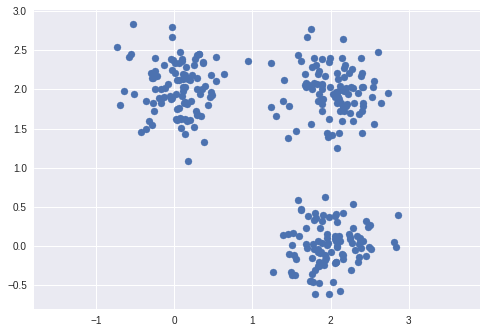

Converged after 3 iterations.


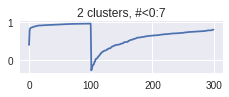

Converged after 4 iterations.


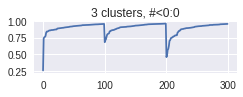

Converged after 4 iterations.


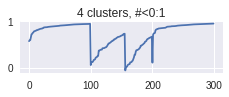

Converged after 7 iterations.


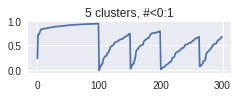

Converged after 6 iterations.


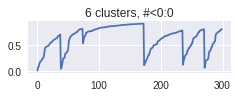

Converged after 6 iterations.


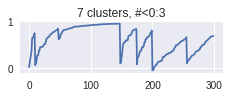

In [0]:
#test k-means
#generate three toy data clouds
data = np.zeros((2,0))
#cloud 1
x, y = np.random.multivariate_normal([2, 0], [[0.1, 0], [0, 0.1]], 100).T
cloud = np.vstack((x,y))
data = np.hstack((data,cloud))
#cloud 2
x, y = np.random.multivariate_normal([0, 2], [[0.1, 0], [0, 0.1]], 100).T
cloud = np.vstack((x,y))
data = np.hstack((data,cloud))
#cloud 3
x, y = np.random.multivariate_normal([2, 2], [[0.1, 0], [0, 0.1]], 100).T
cloud = np.vstack((x,y))
data = np.hstack((data,cloud))

#scatter plot of the data
plt.scatter(data[0,:], data[1,:])
plt.axis('equal')
plt.show()

K_min = 2
K_max = 7
l = 1
for K in range(K_min, K_max+1):
  centroids,closest,dist = kmeans(data, K, max_iter=50, eta=0.05)
  i,j = np.where(closest==1) #j: indexes of the cluster that every point belongs to
  scores,neigh_v = compute_score(data,j)
  
  ax = plt.subplot(int('52'+str(l)))
  ax.set_title(str(K)+' clusters, #<0:'+str(sum(scores<0)))
  ax.plot(scores)
  plt.show()
  l=l+1
  

## **k-means for trump's tweets**

Converged after 33 iterations.


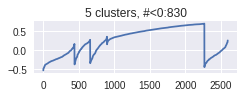

Converged after 28 iterations.


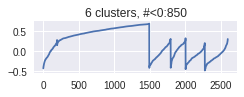

Converged after 31 iterations.


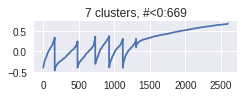

Converged after 35 iterations.


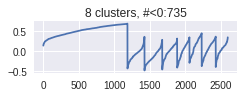

Converged after 19 iterations.


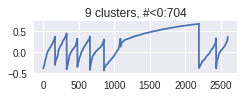

In [19]:
#k-means for trump's tweets
K_min = 5
K_max = 9
l = 1
for K in range(K_min, K_max+1):
  centroids,closest,dist = kmeans(processed_data, K, max_iter=50, eta=0.05)
  
  i,j = np.where(closest==1) #j: indexes of the cluster that every point belongs to
  
  scores,neigh_v = compute_score(processed_data,j)
  
  ax = plt.subplot(int('52'+str(l)))
  ax.set_title(str(K)+' clusters, #<0:'+str(sum(scores<0)))
  ax.plot(scores)
  plt.show()
  l=l+1
  

Converged after 18 iterations.


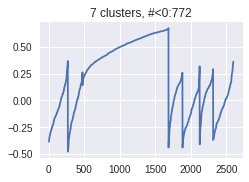

Cluster 1
24                                                                         RT @DanScavino: Congratulations to the 2017 @PinstripeBowl (Yankee Stadium) Champions Iowa @HawkeyeFootball! https://t.co/NlaWU6bKmH
25                                                                                                                     RT @EricTrump: #ThrowbackThursdays @realDonaldTrump ???????????? https://t.co/Z44IObGZ7V
36      WOW @foxandfrlends  “Dossier is bogus. Clinton Campaign DNC funded Dossier. FBI CANNOT (after all of this time) VERIFY CLAIMS IN DOSSIER OF RUSSIA/TRUMP COLLUSION. FBI TAINTED.” And they used this...
73      The Tax Cuts are so large and so meaningful and yet the Fake News is working overtime to follow the lead of their friends the defeated Dems and only demean. This is truly a case where the results ...
89      The train accident that just occurred in DuPont WA shows more than ever why our soon to be submitted infrastructure plan must be approved quickly. Sev

In [20]:
#examining the clusters
pd.options.display.max_colwidth = 200
tweets = dataset['text'].copy()

K = 7 #number of clusters
centroids,closest,dist = kmeans(processed_data, K, max_iter=50, eta=0.05)
i,j = np.where(closest==1) #j: indexes of the cluster that every point belongs to
scores,neigh_v = compute_score(processed_data,j)

ax = plt.subplot(int('221'))
ax.set_title(str(K)+' clusters, #<0:'+str(sum(scores<0)))
ax.plot(scores)
plt.show()

for k in range(K):
  ind = np.where(j==k)
  print('Cluster '+str(k+1))
  print(tweets.iloc[ind])
  